## Huggingface's transformers library

Parts of this code based on https://huggingface.co/transformers/quickstart.html and https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

Huggingface's `transformers` library is a very popular library that contains some of the latest complex architectures based on the Transformer. This library is used by an increasing number of developers and researchers to produce state-of-the-art results in multiple tasks. In this notebook, we will what is arguably the most popular architecture, BERT, for the task of the classification of movie reviews (yes, this task again).

In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Uncomment this cell if you need to install transformers for google colab
!pip install transformers

     |████████████████████████████████| 2.0MB 16.6MB/s 
     |████████████████████████████████| 890kB 51.2MB/s 
     |████████████████████████████████| 3.2MB 47.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=106fb5e0d3bd18a72fe847f857b3c3813622ea854094358216d185a6cb370d1f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


If we are going to use the pre-trained weights provided by `transformers`, we need to make sure that we use the same tokenizer. The following code illustrates how to use the tokenizer bundled with the BERT model. The first thing we need to do is load the tokenizer from the pre-trained model.

In [4]:
from transformers import BertTokenizer, TFBertModel

In [5]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The `encode` will return the word indices. There are several special indices:

* 101 is used to encode the special token `[CLS]`. This token indicates the beginning of the string.
* 102 is used to encode the sentence separator `[SEP]`.

You will observe that the number of tokens does not correspond with the number of words. This is because BERT's tokeniser will split long words into shorter pieces of text. This is BERT's approach to address the problem of unknown words. By splitting long words into multiple tokens, we are less likely to find unknown words.

In [6]:
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokens = tokenizer.encode(text, add_special_tokens=False)
tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

In [7]:
tokenizer.decode(tokens)

'[CLS] who was jim henson? [SEP] jim henson was a puppeteer [SEP]'

The decoded version has converted all uppercase characters to lowercase. This is because we have used the pre-trained model "bert-case-uncased".

The process of tokenising can also be done through two steps: first find the words, then find the word indices. The code below shows that the word "puppeteer" has been split into two tokens: "puppet" and "##eer".

In [8]:
# Tokenize input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
tokenized_text

['[CLS]',
 'who',
 'was',
 'jim',
 'henson',
 '?',
 '[SEP]',
 'jim',
 'henson',
 'was',
 'a',
 'puppet',
 '##eer',
 '[SEP]']

In [9]:
# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
indexed_tokens

[101,
 2040,
 2001,
 3958,
 27227,
 1029,
 102,
 3958,
 27227,
 2001,
 1037,
 13997,
 11510,
 102]

# IMDB data preparation
From https://github.com/strongio/keras-bert/blob/master/keras-bert.ipynb

We need to tokenise the IMDB data (we cannot use the word indices given by Keras). The following code downloads the IMDB data and loads it as a `pandas` data frame.

In [10]:
import os
import re
import pandas as pd
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

In [11]:
train_df, test_df = download_and_load_datasets()
train_df.head()

84131840/84125825 [==============================] - 4s 0us/step


,sentence,sentiment,polarity
0,Unless you are between the ages of 10 and 14 (...,1,0
1,"Wow You guys are way too nice!!!Corny,Corny,Co...",4,0
2,OK. I think the TV show is kind of cute and it...,2,0
3,If you're in the mood for some dopey light ent...,4,0
4,"Before this made for TV movie began, I had rel...",4,0


We now load the text and the labels. We use the "polarity" column for the labels.

In [12]:
import numpy as np
# Create datasets (Only take up to max_seq_length words for memory)
max_seq_length = 500
train_text = train_df['sentence'].tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
#train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = train_df['polarity'].tolist()

test_text = test_df['sentence'].tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
#test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = test_df['polarity'].tolist()


In [13]:
train_text[:3]

['Unless you are between the ages of 10 and 14 (except for the R rating), there are very few things to like here. One or two lines from Kenan Thompson, David Koechner (we really should see him more) and Sam Jackson are humorous and Julianna Margulies is as good as she can be considering her surroundings, but sadly, that\'s it. Poor plot. Poor acting. Worse writing and delivery. The special effects are dismal. As much as the entire situation is an odd and awful joke, the significant individual embedded situations are all equally terrible. If we consider the action portions, well there are unbelievable action sequences in some films that make you giddy and there are some that make you groan. This movie only contains the latter kind. This leaves little left. I\'m so glad I did not pay for this.<br /><br />Despite any hype, I can read and think, so as I sat down to watch, I did not expect anything good. I had no expectations, but was somewhat worried going in. Yet, like a train wreck, one 

In [14]:
train_label[:3]

[0, 0, 0]

In [15]:
train_indices = [tokenizer.encode(t, add_special_tokens=True, max_length=500, padding='max_length', truncation=True) for t in train_text]

In [16]:
test_indices = [tokenizer.encode(t, add_special_tokens=True, max_length=500, padding='max_length', truncation=True) for t in test_text]

If executing the above two lines (which have been commented out) is too slow and your computer has multiple CPUs, you can use the following parallel version that uses Python's `multiprocessing` library instead. Uncomment and execute the following cells.

In [17]:
#from multiprocessing import Pool
#from functools import partial
#def text_to_indices(data, limit=500):
#    "Convert the text to indices and pad-truncate to the maximum number of words"
#    with Pool() as pool:
#        return pool.map(partial(tokenizer.encode,
#                                      add_special_tokens=True, max_length=limit, padding='max_length', truncation=True),
#                         data)

In [18]:
#text_to_indices(["this is sentence 1", "this is sentence 2"], limit=10)

In [19]:
#print("Obtaining indices of train set")
#train_indices = text_to_indices(train_text)
#print("Obtaining indices of test set")
#test_indices = text_to_indices(test_text)

# Results with BERT
Let's now design a simple architecture that uses BERT for binary classification. Our approach will not modify the BERT weights, hence we use the option `trainable=False`.

In [20]:
# Load pre-trained model (weights)
bert = TFBertModel.from_pretrained('bert-base-uncased', trainable=False)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D

Below is the code that implements the model. Given that the BERT layer returns multiple outputs, we must use Keras' [functional API](https://keras.io/guides/functional_api/) where we use functions to define each layer. Each function takes as a parameter the output of the previous layer in the sequence of the model. 

Look, in particular, at the line `last_hidden_states = bert(inputs)[0]`. This line is using our definition of BERT, to which we apply the inputs. The layer returns a tuple of values, and we use the first element only (element with index 0). This element contains the information that we want, which is the list of BERT embeddings of each token.

Then, the final model is defined by defining what are the inputs and the outputs. In the code below, this is done in the line `bert_model = Model(inputs, outputs)`.

In [22]:
# From https://huggingface.co/transformers/_modules/transformers/modeling_tf_bert.html#TFBertModel
#inputs = tf.constant(indexed_tokens)[None, :] # Batch  size 1
inputs = Input(shape=(500,), dtype=tf.int32)
last_hidden_states = bert(inputs)[0]  # The last hidden-state is the first element of the output tuple
average_pooling = GlobalAveragePooling1D()(last_hidden_states) # Average pooling of last hidden states as recommended
outputs = Dense(1, activation=tf.nn.sigmoid)(average_pooling)
bert_model = Model(inputs, outputs)
bert_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [23]:
bert_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [24]:
history = bert_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/20
157/157 [==============================] - 1170s 7s/step - loss: 0.6763 - acc: 0.5886 - val_loss: 0.6119 - val_acc: 0.7254
Epoch 2/20
157/157 [==============================] - 1156s 7s/step - loss: 0.6121 - acc: 0.7167 - val_loss: 0.5607 - val_acc: 0.7998
Epoch 3/20
157/157 [==============================] - 1154s 7s/step - loss: 0.5657 - acc: 0.7729 - val_loss: 0.5338 - val_acc: 0.7642
Epoch 4/20
157/157 [==============================] - 1155s 7s/step - loss: 0.5370 - acc: 0.7821 - val_loss: 0.5017 - val_acc: 0.8222
Epoch 5/20
157/157 [==============================] - 1155s 7s/step - loss: 0.5165 - acc: 0.7920 - val_loss: 0.4834 - val_acc: 0.8154
Epoch 6/20
157/157 [==============================] - 1157s 7s/step - loss: 0.4973 - acc: 0.8038 - val_loss: 0.4681 - val_acc: 0.8306
Epoch 7/20
157/157 [==============================] - 1156s 7s/step - loss: 0.4847 - acc: 0.8024 - val_loss: 0.4601 - val_acc: 0.8090
Epoch 8/20
157/157 [==============================] - 1151s 7s

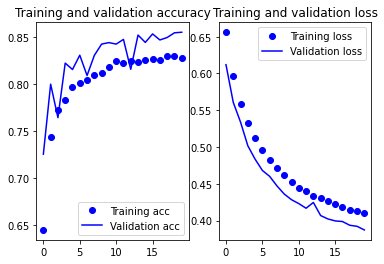

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Results with Average baseline
For comparison, below is a simpler architecture that uses a simple embedding layer instead of BERT, as we have seen in previous notebooks. The system will process exactly the same data.

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D

In [27]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
avg = GlobalAveragePooling1D()(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(avg)
avg_model = Model(inputs, outputs)
avg_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 32)           976704    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 976,737
Trainable params: 976,737
Non-trainable params: 0
_________________________________________________________________


In [28]:
avg_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [29]:
history = avg_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/50
157/157 [==============================] - 3s 16ms/step - loss: 0.6905 - acc: 0.5830 - val_loss: 0.6752 - val_acc: 0.6336
Epoch 2/50
157/157 [==============================] - 2s 15ms/step - loss: 0.6658 - acc: 0.7195 - val_loss: 0.6274 - val_acc: 0.7752
Epoch 3/50
157/157 [==============================] - 2s 15ms/step - loss: 0.6145 - acc: 0.7765 - val_loss: 0.5692 - val_acc: 0.8028
Epoch 4/50
157/157 [==============================] - 2s 16ms/step - loss: 0.5575 - acc: 0.8109 - val_loss: 0.5160 - val_acc: 0.8288
Epoch 5/50
157/157 [==============================] - 2s 15ms/step - loss: 0.5047 - acc: 0.8355 - val_loss: 0.4708 - val_acc: 0.8466
Epoch 6/50
157/157 [==============================] - 2s 15ms/step - loss: 0.4575 - acc: 0.8515 - val_loss: 0.4338 - val_acc: 0.8586
Epoch 7/50
157/157 [==============================] - 2s 15ms/step - loss: 0.4162 - acc: 0.8687 - val_loss: 0.4042 - val_acc: 0.8690
Epoch 8/50
157/157 [==============================] - 2s 15ms/step - 

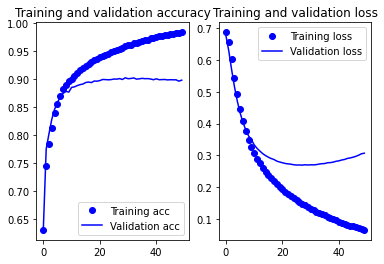

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The system overfits much more than with BERT, but accuracy of the validation data is higher (better) than with BERT. This shows that it makes sense always to try a simple architecture before trying more complex and advanced architectures.

# Results with LSTM baseline
An another baseline, this time using an LSTM layer.

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM

In [32]:
max_features = tokenizer.vocab_size
embeddings_size = 32
inputs = Input(shape=(500,), dtype=tf.int32)
embedding = Embedding(max_features, embeddings_size)(inputs)
lstm = LSTM(embeddings_size, dropout=0.2)(embedding)
outputs = Dense(1, activation=tf.nn.sigmoid)(lstm)
lstm_model = Model(inputs, outputs)
lstm_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           976704    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 985,057
Trainable params: 985,057
Non-trainable params: 0
_________________________________________________________________


In [33]:
lstm_model.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['acc'])

In [34]:
history = lstm_model.fit(np.array(train_indices), np.array(train_label),
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/30
157/157 [==============================] - 35s 36ms/step - loss: 0.6933 - acc: 0.5042 - val_loss: 0.6929 - val_acc: 0.5112
Epoch 2/30
157/157 [==============================] - 5s 32ms/step - loss: 0.6925 - acc: 0.5138 - val_loss: 0.6926 - val_acc: 0.4970
Epoch 3/30
157/157 [==============================] - 5s 32ms/step - loss: 0.6800 - acc: 0.5296 - val_loss: 0.6883 - val_acc: 0.5340
Epoch 4/30
157/157 [==============================] - 5s 32ms/step - loss: 0.6288 - acc: 0.5640 - val_loss: 0.7061 - val_acc: 0.5202
Epoch 5/30
157/157 [==============================] - 5s 32ms/step - loss: 0.5972 - acc: 0.5841 - val_loss: 0.7361 - val_acc: 0.5348
Epoch 6/30
157/157 [==============================] - 5s 33ms/step - loss: 0.6266 - acc: 0.5842 - val_loss: 0.7155 - val_acc: 0.5438
Epoch 7/30
157/157 [==============================] - 5s 32ms/step - loss: 0.5868 - acc: 0.5903 - val_loss: 0.7122 - val_acc: 0.5674
Epoch 8/30
157/157 [==============================] - 5s 33ms/step -

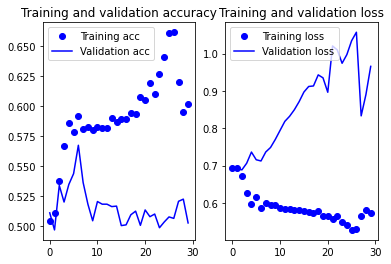

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()